In [1]:
import numpy as np
import os, re, glob
import pandas as pd
from PyPDF2 import PdfReader
top = os.getcwd()
data_dir = os.path.join(top, 'data') # Specify data directoy here

# Construct Calibration Curve

## Standard Peak Assignment (New Run)

- 5.6 = ?
- 6.3 = ?
- 8.1 = ethanol
- 8.9 = n-propanol
- 13.7 = ethyl-acetate
- 14.1 = isobutanol
- 16.0 = n-butanol (internal standard)
- 19.7 = isoamyl alcohol

In [3]:
peakdir = os.path.join(top, 'peak-area')
df_standard = pd.read_csv(os.path.join(peakdir,'standards.csv'))

pattern = r'\d+\.\d+_avg_Area'
std_pattern = r'\d+\.\d+_std_Area'

avg = df_standard.filter(regex=pattern)
avg

,5.6_avg_Area,6.4_avg_Area,8.1_avg_Area,8.9_avg_Area,13.8_avg_Area,14.1_avg_Area,16.0_avg_Area,19.7_avg_Area
0,2.722588,NaN,131363.7,20.326771,302.628711,50.837445,1014.959051,257.989241
1,3.468092,3.272755,129120.8,54.753609,2.391530,238.550999,1070.421082,526.351981
2,2.980861,NaN,131752.9,191.822572,32.253462,524.622548,1018.940443,4.900047
3,3.732605,10.003866,128977.4,366.734757,143.260575,5.802508,971.388359,60.634962


In [4]:
std = df_standard.filter(regex=std_pattern)
std

,5.6_std_Area,6.4_std_Area,8.1_std_Area,8.9_std_Area,13.8_std_Area,14.1_std_Area,16.0_std_Area,19.7_std_Area
0,0.436106,NaN,3837.853412,6.583340,7.964407,1.568399,30.077984,7.098318
1,0.189681,0.091292,1847.686759,2.090423,0.061833,3.538399,16.029537,8.239846
2,0.198321,NaN,2740.347622,3.480990,0.609576,11.373253,21.423112,0.181932
3,0.211640,0.217398,2944.316464,8.146067,2.990219,0.192971,22.991797,1.624316


## Standard Peak Assignment (Older Run)
- 8.1 = methanol
- 11.1 = n-propanol
- 13.7 = ethyl-acetate
- 14.1 = isobutanol
- 16.0 = internal standard
- 19.7 = ??

In [47]:
pattern = r'\d+\.\d+_avg_Area'
avg = df_standard.filter(regex=pattern)
avg

,7.6_avg_Area,11.1_avg_Area,13.8_avg_Area,14.1_avg_Area,16.0_avg_Area,19.7_avg_Area
CL_1,13132.825000,14.711481,161.554555,51.528126,85.128855,212.080334
CL_2,13448.311111,44.434816,2.747743,204.299700,74.508209,219.126457
CL_3,13370.977778,212.146120,21.107370,516.101800,76.958213,60.230514
CL_4,13395.922222,491.955657,66.280760,8.556508,180.813703,58.042748


In [48]:
std_pattern = r'\d+\.\d+_std_Area'
std = df_standard.filter(regex=std_pattern)

std

,7.6_std_Area,11.1_std_Area,13.8_std_Area,14.1_std_Area,16.0_std_Area,19.7_std_Area
CL_1,212.897832,0.211805,2.979884,0.933741,1.963600,3.640260
CL_2,66.530752,0.228078,0.052898,1.119817,0.392539,1.200216
CL_3,172.974782,2.842553,0.473338,7.850704,1.071675,0.779604
CL_4,103.864910,3.861510,0.466654,0.138374,1.375329,0.418637


# Calibration Curve

In [5]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import linregress
from scipy.optimize import curve_fit
import scipy.stats as stats
import numpy as np
import os, re, glob

## Remove misc Compounds

In [6]:
avg_norm = avg.drop(['5.6_avg_Area', '6.4_avg_Area', '8.1_avg_Area'], axis=1)
avg_norm = avg_norm.div(avg_norm['16.0_avg_Area'], axis=0)
avg_norm = avg_norm.drop('16.0_avg_Area', axis=1)
avg_norm

,8.9_avg_Area,13.8_avg_Area,14.1_avg_Area,19.7_avg_Area
0,0.020027,0.298168,0.050088,0.254187
1,0.051151,0.002234,0.222857,0.491724
2,0.188257,0.031654,0.514871,0.004809
3,0.377537,0.147480,0.005973,0.062421


## Individual Plots

In [7]:
def plot(y, c, name='standard.png'):
    """
    Plot individual calibration curve with linear regression for 
    a single wavelength measurment (single dataframe) 
    
    Parameters
    ----------
    df: pd.DataFrame object
        must contain a blank + 6 standard concentraions, 
        specify the rows if necessary
    """
    
    zero = y[0]
    y = [i - zero for i in y]
    print(f'y values: {y}')
    print(f'x values: {c}')

    x = np.array(c)
    y = np.array(y)

    def model(x, m):
        return m * x

    slope, _ = curve_fit(model, x, y)
    slope = slope[0]

    x_space = np.linspace(min(x), max(x), 1000)
    y_fit = slope * x_space

    ss_res = np.sum((y - (slope * x))**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    ss_tot_null = np.sum(y**2)  
    r2 = 1 - (ss_res / ss_tot)
    r2_null = 1 - (ss_res / ss_tot_null)
    print(f"r, 2: {r2}")
    print(f"r2_null: {r2_null}")

    fig, ax = plt.subplots()
    ax.plot(c, y, marker='o', linestyle='')
    ax.plot(x_space, y_fit, 'k--', label=f'y={slope:.3f}x, R^2 = {r2_null:.5f}')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_ylabel('Abundance')
    ax.set_xlabel('Concentration (ppm)')
    ax.set_title(f'{name}')
    ax.grid(True)
    ax.legend()
    plt.savefig(f'Visualizations/{name}')

In [8]:
# c = [10, 100, 500, 1000]
# for col in avg_norm.columns:
#     y = avg_norm[col].to_list()
#     y = sorted(y)
#     plot(y, c, name=f'{col}.png')

## Combined Plots

In [9]:
def plots(df, ax):
    """
    Plot calirbation curves with linear regression for 
    multiple wavelegnths on a single plot 
    
    Parameters
    ----------
    dfs: list of pd.DataFrame object
        each dataframe must contain a blank + 6 standard 
        concentraions, specify the rows if necessary
    """
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    labels = ['1-propanol', 'ethyl acetate', 'isobutanol', 'isoamyl alcohol']
    legend_handles = []

    c = [0, 10, 100, 500, 1000]

    for index, col in enumerate(df.columns):
        y = df[col].to_list()
        y = sorted(y)
        y.insert(0, 0)

        x = np.array(c)
        y = np.array(y)

        def model(x, m):
            return m * x

        slope, _ = curve_fit(model, x, y)
        slope = slope[0]

        x_space = np.linspace(min(x), max(x), 100)
        y_fit = slope * x_space

        ss_res = np.sum((y - slope * x)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r2 = 1 - (ss_res / ss_tot)

        ax.plot(c, y, marker='o', linestyle='')
        ax.plot(x_space, y_fit, 'k--')
        legend_handles.append(
            mlines.Line2D([], [], color=colors[index], marker='o', linestyle='',
                          label=f'{labels[index]}: \n m={slope:.4e}, R^2 = {r2:.5f}')
        )
        print(df[col].name, labels[index])
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_ylabel('Normalized Average Peak Area')
    ax.set_xlabel('Concentration (ppm)')
    ax.set_title(f'Standard Calibration Curves')
    ax.grid(True)
    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.8), labelspacing=1.2)
    plt.savefig('Visualizations/calibration_main.png', bbox_inches='tight')

8.9_avg_Area 1-propanol
13.8_avg_Area ethyl acetate
14.1_avg_Area isobutanol
19.7_avg_Area isoamyl alcohol


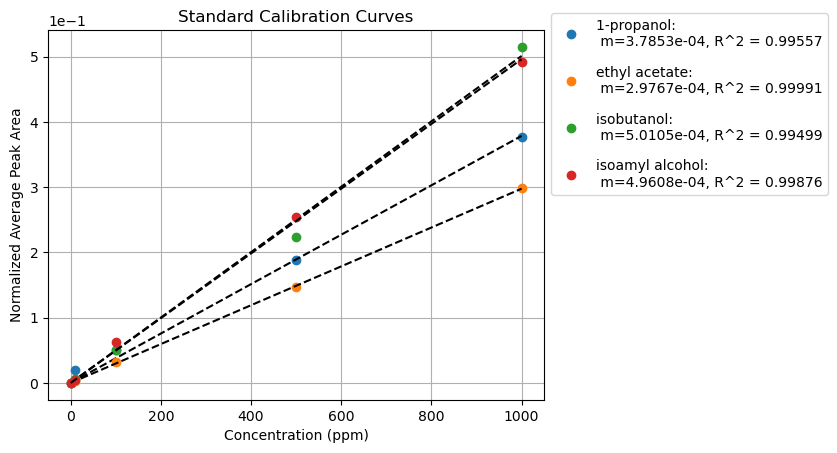

In [10]:
fig, ax = plt.subplots()
plots(avg_norm, ax)

# Individual Plots Combioned

In [11]:
def plot_standrad_ax(df, axes):
    """
    Plot individual calibration curves with linear regression 
    in a single plot
    
    Parameters
    ----------
    dfs_broken: list of pd.DataFrame object
        each dataframe must contain a blank + 6 standard 
        concentraions, specify the rows if necessary, make 
        sure indicies properly aligned
    """
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    labels = ['1-propanol', 'ethyl acetate', 'isobutanol', 'isoamyl alcohol']
    c = [0, 10, 100, 500, 1000]

    def indiv_plot(i, j, y, color, label):
        y = sorted(y)
        y.insert(0, 0)

        x = np.array(c)
        y = np.array(y)

        def model(x, m):
            return m * x

        slope, _ = curve_fit(model, x, y)
        slope = slope[0]

        x_space = np.linspace(min(x), max(x), 100)
        y_fit = slope * x_space

        ss_res = np.sum((y - slope * x)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r2 = 1 - (ss_res / ss_tot)

        axes[i, j].plot(c, y, marker='o', linestyle='', color=color)
        axes[i, j].plot(x_space, y_fit, 'k--', label=f'm={slope:.3f}, R^2 = {r2:.5f}')
                
        axes[i, j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        axes[i, j].set_ylabel('Normalized Average Peak Area')
        axes[i, j].set_xlabel('Concentration (ppm)')
        axes[i, j].set_title(f'{label} Calibration Curve')
        axes[i, j].grid(True)
        axes[i, j].legend()
    
    indiv_plot(0, 0, df['8.9_avg_Area'].to_list(), colors[0], labels[0])
    indiv_plot(0, 1, df['13.8_avg_Area'].to_list(), colors[1], labels[1])
    indiv_plot(1, 0, df['14.1_avg_Area'].to_list(), colors[2], labels[2])
    indiv_plot(1, 1, df['19.7_avg_Area'].to_list(), colors[3], labels[3])

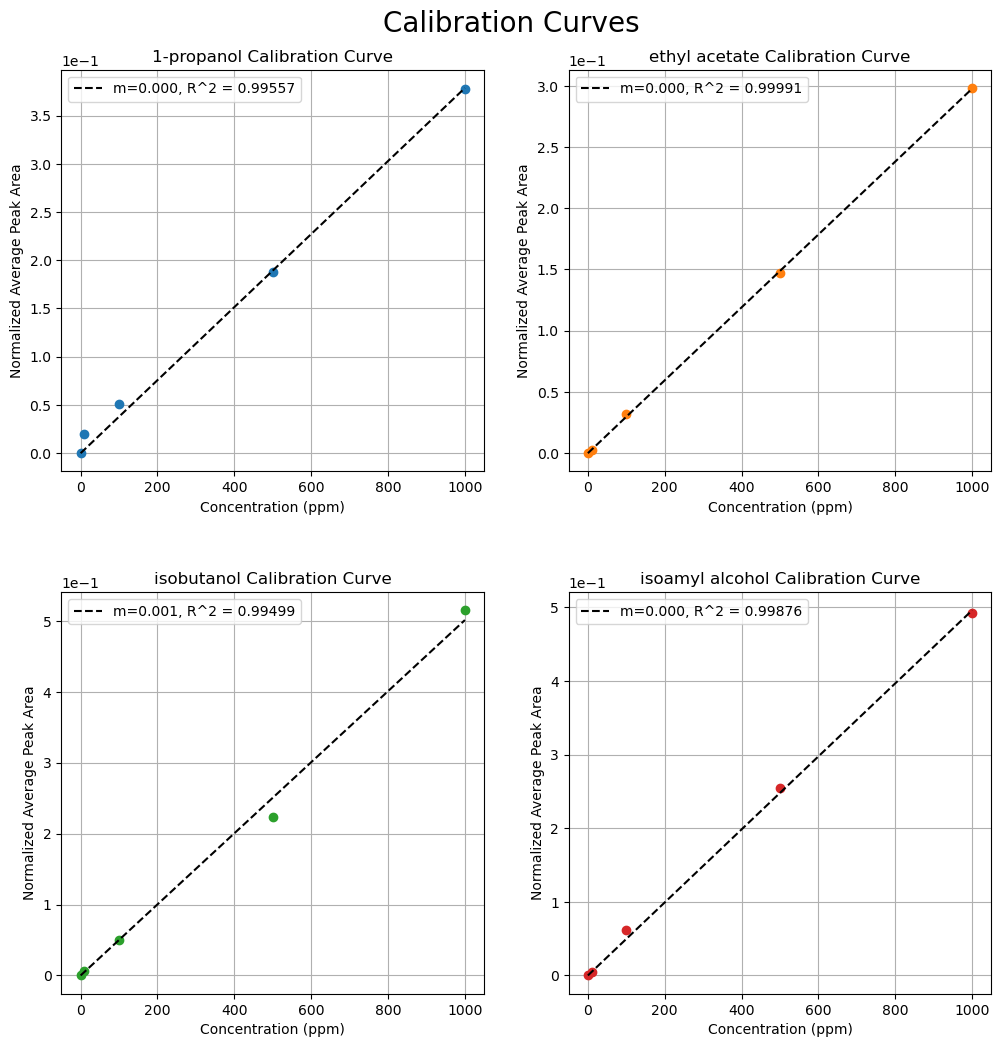

In [107]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plot_standrad_ax(avg_norm, axes)
fig.suptitle("Calibration Curves", fontsize=20, y=0.93)
plt.savefig('Visualizations/calibration_all.png', bbox_inches="tight")

# Sample Peak Assignment

- 8.1 peak in standard == 7.6 peak in samples == ethanol (obvious one)
- 8.9 peak in standard == 11.1 peak in samples == n-propanol
- 

In [13]:
peakdir = os.path.join(top, 'peak-area')
df_sample = pd.read_csv(os.path.join(peakdir,'samples.csv'))

pattern = r'\d+\.\d+_avg_Area'
std_pattern = r'\d+\.\d+_std_Area'

avg = df_sample.filter(regex=pattern)
avg

,5.9_avg_Area,6.4_avg_Area,7.6_avg_Area,11.1_avg_Area,13.8_avg_Area,14.1_avg_Area,16.0_avg_Area,18.7_avg_Area,19.5_avg_Area,19.7_avg_Area
0,NaN,NaN,13189.111111,21.317650,NaN,12.248300,82.953060,NaN,NaN,7.834658
1,NaN,2.546824,11715.100000,6.342900,1.616551,21.921757,83.705750,0.722409,34.402772,14.742714
2,3.84904,2.169857,11299.555556,11.041370,2.977620,20.667643,86.182548,NaN,37.887647,18.654211
3,NaN,1.756802,12114.555556,16.222469,2.666489,12.824934,119.157831,NaN,11.188203,5.867513
4,NaN,2.781473,12269.000000,3.606603,7.843857,15.725813,87.476163,NaN,42.507867,13.585240


In [16]:
avg.to_latex('sample_avg_peak_area.tex')

In [14]:
std = df_sample.filter(regex=std_pattern)
std

,5.9_std_Area,6.4_std_Area,7.6_std_Area,11.1_std_Area,13.8_std_Area,14.1_std_Area,16.0_std_Area,18.7_std_Area,19.5_std_Area,19.7_std_Area
0,NaN,NaN,123.026406,0.264010,NaN,0.116338,0.805496,NaN,NaN,0.126155
1,NaN,0.052698,237.456209,0.168285,0.044840,0.490223,1.769545,0.0,0.682500,0.234583
2,0.0,0.370416,75.760208,0.095512,0.058604,0.143372,0.511195,NaN,0.264937,0.283424
3,NaN,0.048301,81.910969,0.182946,0.031539,0.137370,0.805836,NaN,0.063288,0.161361
4,NaN,0.047202,12.521182,0.016257,0.048710,0.053215,0.411465,NaN,0.030428,0.127081
